In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install pygeohash
import pygeohash as gh
import seaborn as sns

from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error as Kmse
from keras import backend as K

import time

  Preparing metadata (setup.py) ... done
  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6151 sha256=1aaab958cf384c57679af3e58ee7eac3667faf52dd88a5ad3e850561ad9ec2a5
  Stored in directory: /root/.cache/pip/wheels/28/ec/b6/beadf7295a623f528507691fb0d471b50d064ae9bbad420b8f
Successfully built pygeohash


## Function definition

In [7]:
# Function to do cross validation on a model
def application_cross_val(model, X, y):

    # Définition des métriques de score. --definition of score metrics
    scoring = {'MAE': make_scorer(mean_absolute_error), 'MSE': make_scorer(metrics.mean_squared_error), 'RMSE': make_scorer(metrics.mean_squared_error, squared=False), 'R2': make_scorer(r2_score)}

    # Validation croisée avec 5 plis (folds) et scores MAE et R2-- cross validation with 5 folds and mae scores and R2
    results = cross_validate(model, X, y, cv=5, scoring=scoring)

    # Récupération des scores MAE et R2-- Recovery of mae and r2 scores
    mae_scores = results['test_MAE']
    mse_scores = results['test_MSE']
    rmse_scores = results['test_RMSE']
    r2_scores = results['test_R2']

    # Calcul de la moyenne des scores (MAE moyen et R2 moyen)--calculation of avg scores (avg mae and avg r2)
    mean_mae_score = mae_scores.mean()
    mean_mse_score = mse_scores.mean()
    mean_rmse_score = rmse_scores.mean()
    mean_r2_score = r2_scores.mean()

    # Affichage des résultats-- display results
    print("Scores de validation croisée - MAE:")
    print(mae_scores)
    print("MAE moyen : ", mean_mae_score)
    print()
    print("Scores de validation croisée - MSE:")
    print(mse_scores)
    print("MSE moyen : ", mean_mse_score)
    print()
    print("Scores de validation croisée - RMSE:")
    print(rmse_scores)
    print("RMSE moyen : ", mean_rmse_score)
    print()
    print("Scores de validation croisée - R2:")
    print(r2_scores)
    print("R2 moyen : ", mean_r2_score)

# Function to compute metrics of regression model
def compute_error(y_pred, y_test):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_pred,y_test))
    print('Mean Squared Error:', metrics.mean_squared_error(y_pred,y_test))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_pred,y_test)))

    # R² is a “number that indicates the proportion of the variance in the dependent variable that is predictable from the
    # independent variable(s)”. Basically, how accurate is our model)
    print('Accuracy (r2 score):', metrics.r2_score(y_pred,y_test))

def calculate_days(row):
    days = (row['RAD_DATE_PRISE'] - row['date_plant']).days
    return days

def plant_date(row):
    return row['RAD_DATE_PRISE'] == row['date_plant']

# Function to cut off SIGLE if necessary
def modify_sigle(row):
    if "'" in row['specie_latin']:
        return row['SIGLE'][:-2]
    else:
        return row['SIGLE']

# Function to create RMSE loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(Kmse(y_true, y_pred)) #need mse function from keras and not sklearn because it will return a tensor object, needed for the neural network loss

# Function to plot MAE per epoch graph of training and validation data
def mae_graph(trained_model):
    plt.figure(figsize=(5, 5))
    plt.plot(trained_model.history['mae'])
    plt.plot(trained_model.history['val_mae'])
    plt.title('model loss (MAE)')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

# Function to plot RMSE per epoch graph of training and validation data
def rmse_graph(trained_model):
    plt.figure(figsize=(5, 5))
    # plt.plot(trained_model.history['loss'])
    # plt.plot(trained_model.history['val_loss'])
    plt.plot(trained_model.history['rmse'])
    plt.plot(trained_model.history['val_rmse'])
    plt.title('model loss (RMSE)')
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()


## Data import

### Public trees inventory of Montreal

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Public trees inventory of Montreal
df_public_trees = pd.read_excel("/content/drive/MyDrive/corrected_trees_MTL.xlsx")
df_public_trees.head()

,inventory,district_id,district,street,street_side,civic_number,location_number,tree_state,location_type,specie_latin_original,...,uqam_code,code,family,genus,func_group,specie_latin,specie_latin_cleaned,specie_french,specie_english,coord
0,H,1,Ahuntsic - Cartierville,NaN,NaN,NaN,6,Inconnu,Parterre Gazonné,Gleditsia triacanthos 'Skyline',...,GLTR,GLTR,Fabaceae,Gleditsia,4B,Gleditsia triacanthos 'Skyline',Gleditsia triacanthos,Févier Skyline,Skyline Honey-Locust,"45.535151,-73.715515"
1,H,1,Ahuntsic - Cartierville,NaN,NaN,NaN,7,Inconnu,Parterre Gazonné,Gleditsia triacanthos 'Skyline',...,GLTR,GLTR,Fabaceae,Gleditsia,4B,Gleditsia triacanthos 'Skyline',Gleditsia triacanthos,Févier Skyline,Skyline Honey-Locust,"45.535219,-73.715595"
2,H,1,Ahuntsic - Cartierville,NaN,NaN,NaN,8,Inconnu,Parterre Gazonné,Gymnocladus dioicus,...,GYDI,GYDI,Fabaceae,Gymnocladus,4B,Gymnocladus dioicus,Gymnocladus dioicus,Chicot du Canada,Kentucky Coffee Tree,"45.535105,-73.715659"
3,H,1,Ahuntsic - Cartierville,NaN,NaN,NaN,9,Inconnu,Parterre Gazonné,Fraxinus nigra 'Fall Gold',...,FRNI,FRNI,Oleaceae,Fraxinus,2C,Fraxinus nigra 'Fall Gold',Fraxinus nigra,Frêne noir Fall Gold,Fall Gold Black Ash,"45.535617,-73.715298"
4,H,1,Ahuntsic - Cartierville,NaN,NaN,NaN,10,Inconnu,Parterre Gazonné,Quercus rubra,...,QURU,QURU,Fagaceae,Quercus,4A,Quercus rubra,Quercus rubra,Chêne rouge,Red Oak,"45.535598,-73.715596"


In [10]:
df_public_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337080 entries, 0 to 337079
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   inventory              337080 non-null  object 
 1   district_id            337080 non-null  int64  
 2   district               337080 non-null  object 
 3   street                 228087 non-null  object 
 4   street_side            228087 non-null  object 
 5   civic_number           178805 non-null  float64
 6   location_number        337080 non-null  int64  
 7   tree_state             337080 non-null  object 
 8   location_type          337080 non-null  object 
 9   specie_latin_original  337080 non-null  object 
 10  DBH                    336444 non-null  float64
 11  date_measures          337080 non-null  object 
 12  date_plant             337080 non-null  object 
 13  ID_SylvCiT_code        337080 non-null  int64  
 14  health_condition_str   337080 non-nu

In [11]:
df_public_trees["uqam_code"]

0         GLTR
1         GLTR
2         GYDI
3         FRNI
4         QURU
          ... 
337075    GYDI
337076    GYDI
337077    GYDI
337078    GYDI
337079    GYDI
Name: uqam_code, Length: 337080, dtype: object

In [12]:
df_public_trees[["specie_latin","specie_latin_cleaned"]]

,specie_latin,specie_latin_cleaned
0,Gleditsia triacanthos 'Skyline',Gleditsia triacanthos
1,Gleditsia triacanthos 'Skyline',Gleditsia triacanthos
2,Gymnocladus dioicus,Gymnocladus dioicus
3,Fraxinus nigra 'Fall Gold',Fraxinus nigra
4,Quercus rubra,Quercus rubra
...,...,...
337075,Gymnocladus dioicus,Gymnocladus dioicus
337076,Gymnocladus dioicus,Gymnocladus dioicus
337077,Gymnocladus dioicus,Gymnocladus dioicus
337078,Gymnocladus dioicus,Gymnocladus dioicus


### DHP history of Montreal trees

In [13]:
# Import DHP history of Montreal trees
df_dhp_hist = pd.read_excel("/content/drive/MyDrive/Inventaire_et_historique_dhp.xlsx", sheet_name=1)
df_dhp_hist.head()


,INV_TYPE,EMP_NO,RAD_DHP,RAD_DATE_PRISE,Essence_latin,SIGLE,Essence_fr,Date_plantation,Longitude,Latitude,Genre,Famille
0,H,2,5,2004-06-16 00:00:00,Acer platanoides 'Columnare',ACPL,Érable de Norvège colonnaire,2004-06-16,-73.572563,45.514031,Acer,Sapindaceae
1,H,6,5,2004-06-10 00:00:00,Gleditsia triacanthos 'Skyline',GLTR,Févier Skyline,2004-06-10,-73.715515,45.535151,Gleditsia,Fabaceae
2,H,6,25,2018-06-26 00:00:00,Gleditsia triacanthos 'Skyline',GLTR,Févier Skyline,2004-06-10,-73.715515,45.535151,Gleditsia,Fabaceae
3,H,7,32,2018-06-27 00:00:00,Gleditsia triacanthos 'Skyline',GLTR,Févier Skyline,2004-06-18,-73.715595,45.535219,Gleditsia,Fabaceae
4,H,8,5,2004-06-10 00:00:00,Gymnocladus dioicus,GYDI,Chicot du Canada,2004-06-10,-73.715659,45.535105,Gymnocladus,Fabaceae


## Preprocessing

### Merging

In [14]:
# Deletion of useless columns
df_public_trees = df_public_trees[["inventory", "location_number", "date_plant","uqam_code","specie_latin","DBH", "date_measures","coord"]]
df_public_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337080 entries, 0 to 337079
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   inventory        337080 non-null  object 
 1   location_number  337080 non-null  int64  
 2   date_plant       337080 non-null  object 
 3   uqam_code        336222 non-null  object 
 4   specie_latin     337080 non-null  object 
 5   DBH              336444 non-null  float64
 6   date_measures    337080 non-null  object 
 7   coord            337077 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 20.6+ MB


In [15]:
# Addition of DHP history information
df_dhp_hist = df_dhp_hist.rename(columns={"INV_TYPE": "inventory","EMP_NO": "location_number","Essence_latin":"specie_latin"})
df_trees = pd.merge(df_dhp_hist, df_public_trees, on=["inventory","location_number","specie_latin"])
df_trees = df_trees.drop(["DBH", "date_measures","Essence_fr","coord","Date_plantation"], axis=1)
df_trees.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 644829 entries, 0 to 644828
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   inventory        644829 non-null  object 
 1   location_number  644829 non-null  int64  
 2   RAD_DHP          644829 non-null  int64  
 3   RAD_DATE_PRISE   644829 non-null  object 
 4   specie_latin     644829 non-null  object 
 5   SIGLE            644829 non-null  object 
 6   Longitude        644826 non-null  float64
 7   Latitude         644826 non-null  float64
 8   Genre            640601 non-null  object 
 9   Famille          640601 non-null  object 
 10  date_plant       644829 non-null  object 
 11  uqam_code        644296 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 64.0+ MB


### Dates preprocessing (RAD_DATE_PRISE et date_plantation)

Conversion of dates to date type :

In [16]:
df_trees['date_plant'] = pd.to_datetime(df_trees['date_plant'], errors='coerce')
df_trees['RAD_DATE_PRISE'] = pd.to_datetime(df_trees['RAD_DATE_PRISE'], errors = 'coerce')

<ipython-input-16-131a66cb738e>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_trees['date_plant'] = pd.to_datetime(df_trees['date_plant'], errors='coerce')


In [17]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 644829 entries, 0 to 644828
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   inventory        644829 non-null  object        
 1   location_number  644829 non-null  int64         
 2   RAD_DHP          644829 non-null  int64         
 3   RAD_DATE_PRISE   644597 non-null  datetime64[ns]
 4   specie_latin     644829 non-null  object        
 5   SIGLE            644829 non-null  object        
 6   Longitude        644826 non-null  float64       
 7   Latitude         644826 non-null  float64       
 8   Genre            640601 non-null  object        
 9   Famille          640601 non-null  object        
 10  date_plant       327196 non-null  datetime64[ns]
 11  uqam_code        644296 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(6)
memory usage: 64.0+ MB


In [18]:
df_trees[df_trees['RAD_DATE_PRISE'] < df_trees['date_plant']]

,inventory,location_number,RAD_DHP,RAD_DATE_PRISE,specie_latin,SIGLE,Longitude,Latitude,Genre,Famille,date_plant,uqam_code
1,H,6,5,2004-06-10,Gleditsia triacanthos 'Skyline',GLTR,-73.715515,45.535151,Gleditsia,Fabaceae,2004-10-06,GLTR
4,H,8,5,2004-06-10,Gymnocladus dioicus,GYDI,-73.715659,45.535105,Gymnocladus,Fabaceae,2004-10-06,GYDI
36,H,27,5,2004-07-12,Acer platanoides 'Deborah',ACPL,-73.652695,45.570248,Acer,Sapindaceae,2004-12-07,ACPL
39,H,28,5,2004-07-12,Acer platanoides 'Deborah',ACPL,-73.652806,45.570297,Acer,Sapindaceae,2004-12-07,ACPL
42,H,30,5,2004-07-12,Acer platanoides 'Deborah',ACPL,-73.716914,45.536621,Acer,Sapindaceae,2004-12-07,ACPL
...,...,...,...,...,...,...,...,...,...,...,...,...
644017,R,570005,5,2022-10-11,Ginkgo biloba 'Autumn Gold',GIBI,-73.645017,45.464428,Ginkgo,Ginkgoaceae,2022-11-10,GIBI
644030,R,570305,5,2022-10-11,Syringa reticulata 'Ivory Silk',SYRE,-73.628332,45.488542,Syringa,Oleaceae,2022-11-10,SYRE
644069,R,571325,5,2022-05-09,Amelanchier canadensis,AMCA,-73.602418,45.450232,Amelanchier,Rosaceae,2022-09-05,AMCA
644374,R,575525,5,2018-05-11,Ostrya virginiana,OSVI,-73.635991,45.513599,Ostrya,Betulaceae,2018-11-05,OSVI


371 observations have a DBH statement date prior to the plantation date, which is inconsistent. We have to remove them :

In [19]:
subset = df_trees[df_trees['RAD_DATE_PRISE'] < df_trees['date_plant']]
df_trees = df_trees.drop(subset.index)

In [20]:
df_trees[df_trees['RAD_DATE_PRISE'] < df_trees['date_plant']]

,inventory,location_number,RAD_DHP,RAD_DATE_PRISE,specie_latin,SIGLE,Longitude,Latitude,Genre,Famille,date_plant,uqam_code


In [21]:
df_trees["RAD_DATE_PRISE"].describe()

<ipython-input-21-7fcf1e1942e7>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_trees["RAD_DATE_PRISE"].describe()


count                  630793
unique                   6642
top       1998-08-01 00:00:00
freq                    13987
first     1900-02-01 00:00:00
last      2023-12-04 00:00:00
Name: RAD_DATE_PRISE, dtype: object

We also remove observations with DBH statement date after the one of the last modifications of data, which is 2023-05-12.

In [22]:
upper_date = pd.to_datetime("12/05/2023")
df_trees[df_trees["RAD_DATE_PRISE"] > upper_date]

,inventory,location_number,RAD_DHP,RAD_DATE_PRISE,specie_latin,SIGLE,Longitude,Latitude,Genre,Famille,date_plant,uqam_code


In [19]:
#df_trees["RAD_DATE_PRISE"].isna().sum()

232

In [20]:
#df_trees = df_trees.dropna(subset="RAD_DATE_PRISE")

In [21]:
#df_trees["RAD_DATE_PRISE"].isna().sum()

0

In [ ]:
#df_trees["Date_plantation"].isna().sum()

We have a lot of plantation date missing. For now we don't remove the observations with a missing one because we will try later to impute them and compare model's prediction performance.

In [23]:
df_trees['RAD_DATE_PRISE_year'] = df_trees['RAD_DATE_PRISE'].dt.year
df_trees['RAD_DATE_PRISE_month'] = df_trees['RAD_DATE_PRISE'].dt.month
df_trees['RAD_DATE_PRISE_day'] = df_trees['RAD_DATE_PRISE'].dt.day

df_trees['date_plant_year'] = df_trees['date_plant'].dt.year
df_trees['date_plant_month'] = df_trees['date_plant'].dt.month
df_trees['date_plant_day'] = df_trees['date_plant'].dt.day


In [24]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631025 entries, 0 to 644828
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   inventory             631025 non-null  object        
 1   location_number       631025 non-null  int64         
 2   RAD_DHP               631025 non-null  int64         
 3   RAD_DATE_PRISE        630793 non-null  datetime64[ns]
 4   specie_latin          631025 non-null  object        
 5   SIGLE                 631025 non-null  object        
 6   Longitude             631022 non-null  float64       
 7   Latitude              631022 non-null  float64       
 8   Genre                 626877 non-null  object        
 9   Famille               626877 non-null  object        
 10  date_plant            313392 non-null  datetime64[ns]
 11  uqam_code             630520 non-null  object        
 12  RAD_DATE_PRISE_year   630793 non-null  float64       
 13 

### Code UQÀM and SIGLE preprocessing

We want to keep the sigle of species without the cultivar (the name between quotes). So we are going to keep the sigle instead of code UQAM


In [25]:
df_trees = df_trees.drop(columns="uqam_code")
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631025 entries, 0 to 644828
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   inventory             631025 non-null  object        
 1   location_number       631025 non-null  int64         
 2   RAD_DHP               631025 non-null  int64         
 3   RAD_DATE_PRISE        630793 non-null  datetime64[ns]
 4   specie_latin          631025 non-null  object        
 5   SIGLE                 631025 non-null  object        
 6   Longitude             631022 non-null  float64       
 7   Latitude              631022 non-null  float64       
 8   Genre                 626877 non-null  object        
 9   Famille               626877 non-null  object        
 10  date_plant            313392 non-null  datetime64[ns]
 11  RAD_DATE_PRISE_year   630793 non-null  float64       
 12  RAD_DATE_PRISE_month  630793 non-null  float64       
 13 

In [26]:
df_trees["SIGLE"].isna().sum()

0

### Inventory type preprocessing

In [27]:
df_trees["inventory"].isna().sum()

0

In [43]:
pd.get_dummies(df_trees['inventory'], prefix='inventory')

,inventory_H,inventory_R
0,1,0
2,1,0
3,1,0
5,1,0
6,1,0
...,...,...
644824,0,1
644825,0,1
644826,0,1
644827,0,1


In [28]:
# One hot encoding INV_TYPE
df_trees = pd.concat([df_trees,pd.get_dummies(df_trees['inventory'], prefix='inventory')],axis=1)

# now drop the original 'INV_TYPE' column
df_trees.drop(['inventory'],axis=1, inplace=True)

In [29]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631025 entries, 0 to 644828
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       631025 non-null  int64         
 1   RAD_DHP               631025 non-null  int64         
 2   RAD_DATE_PRISE        630793 non-null  datetime64[ns]
 3   specie_latin          631025 non-null  object        
 4   SIGLE                 631025 non-null  object        
 5   Longitude             631022 non-null  float64       
 6   Latitude              631022 non-null  float64       
 7   Genre                 626877 non-null  object        
 8   Famille               626877 non-null  object        
 9   date_plant            313392 non-null  datetime64[ns]
 10  RAD_DATE_PRISE_year   630793 non-null  float64       
 11  RAD_DATE_PRISE_month  630793 non-null  float64       
 12  RAD_DATE_PRISE_day    630793 non-null  float64       
 13 

### Geographical coordinates preprocessing

In [30]:
sub_df = df_trees[["Latitude", "Longitude"]]
sub_df.groupby(["Latitude", "Longitude"]).size()

Latitude   Longitude 
2.617462   -73.638517    1
2.617966   -73.638016    1
2.621544   -73.634458    1
2.621572   -73.634431    1
2.621613   -73.634390    1
                        ..
45.702595  -73.478068    1
           -73.477977    1
46.405088  -73.718525    1
48.797614  -73.640669    1
72.351564  -73.779993    1
Length: 313903, dtype: int64

In [31]:
#Use geohashes to represent location data
df_trees['geohash']= df_trees.apply(lambda x: gh.encode(x["Latitude"], x["Longitude"], precision=5), axis=1)


In [32]:
df_trees["geohash"].nunique()

55

Grâce au geohash, on passe de 332060 pairs de valeurs uniques (latitude, longitude) à 56 valeurs uniques. Cela signifie que le geohashage a permis de regrouper ensemble sous un même geohash les arbres proches géographiquement, nous donnant de l'informations sur la proximité des arbres. The geohash allowed us to group under a same geohash trees geographically close. Indeed, we had 332060 pairs of single values and after geohash processing we onely have 56.

In [33]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631025 entries, 0 to 644828
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       631025 non-null  int64         
 1   RAD_DHP               631025 non-null  int64         
 2   RAD_DATE_PRISE        630793 non-null  datetime64[ns]
 3   specie_latin          631025 non-null  object        
 4   SIGLE                 631025 non-null  object        
 5   Longitude             631022 non-null  float64       
 6   Latitude              631022 non-null  float64       
 7   Genre                 626877 non-null  object        
 8   Famille               626877 non-null  object        
 9   date_plant            313392 non-null  datetime64[ns]
 10  RAD_DATE_PRISE_year   630793 non-null  float64       
 11  RAD_DATE_PRISE_month  630793 non-null  float64       
 12  RAD_DATE_PRISE_day    630793 non-null  float64       
 13 

In [34]:
# reset index
df_trees.reset_index(drop=True, inplace=True)

In [35]:
df_trees["geohash"]

0         f25dv
1         f25e4
2         f25e4
3         f25e4
4         f25e4
          ...  
631020    f25dk
631021    f25et
631022    f25et
631023    f25et
631024    f25et
Name: geohash, Length: 631025, dtype: object

In [36]:
# Breaking the geohash in 3 features
fh_geohash = FeatureHasher(n_features=3, input_type='string')
obj=df_trees['geohash'].to_numpy()
obj =obj.reshape(*obj.shape, 1)
hashed_features = fh_geohash.transform(obj)
hashed_features_df = pd.DataFrame(hashed_features.toarray(), columns=['geoloc_0', 'geoloc_1', 'geoloc_2'])
df_trees = df_trees.join(hashed_features_df)


In [37]:
df_trees.drop(['Longitude','Latitude'],axis=1, inplace=True)


In [38]:
df_trees

,location_number,RAD_DHP,RAD_DATE_PRISE,specie_latin,SIGLE,Genre,Famille,date_plant,RAD_DATE_PRISE_year,RAD_DATE_PRISE_month,RAD_DATE_PRISE_day,date_plant_year,date_plant_month,date_plant_day,inventory_H,inventory_R,geohash,geoloc_0,geoloc_1,geoloc_2
0,2,5,2004-06-16,Acer platanoides 'Columnare',ACPL,Acer,Sapindaceae,2004-06-16,2004.0,6.0,16.0,2004.0,6.0,16.0,1,0,f25dv,0.0,0.0,-1.0
1,6,25,2018-06-26,Gleditsia triacanthos 'Skyline',GLTR,Gleditsia,Fabaceae,2004-10-06,2018.0,6.0,26.0,2004.0,10.0,6.0,1,0,f25e4,1.0,0.0,0.0
2,7,32,2018-06-27,Gleditsia triacanthos 'Skyline',GLTR,Gleditsia,Fabaceae,2004-06-18,2018.0,6.0,27.0,2004.0,6.0,18.0,1,0,f25e4,1.0,0.0,0.0
3,9,5,2018-07-12,Fraxinus nigra 'Fall Gold',FRNI,Fraxinus,Oleaceae,2004-06-18,2018.0,7.0,12.0,2004.0,6.0,18.0,1,0,f25e4,1.0,0.0,0.0
4,10,34,2018-06-27,Quercus rubra,QURU,Quercus,Fagaceae,2004-06-18,2018.0,6.0,27.0,2004.0,6.0,18.0,1,0,f25e4,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631020,596685,5,2022-11-11,Aesculus hippocastanum 'Baumanii',AEHI,Aesculus,Sapindaceae,2022-11-11,2022.0,11.0,11.0,2022.0,11.0,11.0,0,1,f25dk,0.0,0.0,1.0
631021,596785,34,2023-05-03,Populus,PO,NaN,NaN,NaT,2023.0,5.0,3.0,NaN,NaN,NaN,0,1,f25et,-1.0,0.0,0.0
631022,596785,30,2023-05-03,Populus,PO,NaN,NaN,NaT,2023.0,5.0,3.0,NaN,NaN,NaN,0,1,f25et,-1.0,0.0,0.0
631023,596805,52,2023-05-03,Populus,PO,NaN,NaN,NaT,2023.0,5.0,3.0,NaN,NaN,NaN,0,1,f25et,-1.0,0.0,0.0


### DBH preprocessing

In [39]:
df_trees["RAD_DHP"].isna().sum()

0

In [40]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631025 entries, 0 to 631024
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       631025 non-null  int64         
 1   RAD_DHP               631025 non-null  int64         
 2   RAD_DATE_PRISE        630793 non-null  datetime64[ns]
 3   specie_latin          631025 non-null  object        
 4   SIGLE                 631025 non-null  object        
 5   Genre                 626877 non-null  object        
 6   Famille               626877 non-null  object        
 7   date_plant            313392 non-null  datetime64[ns]
 8   RAD_DATE_PRISE_year   630793 non-null  float64       
 9   RAD_DATE_PRISE_month  630793 non-null  float64       
 10  RAD_DATE_PRISE_day    630793 non-null  float64       
 11  date_plant_year       313392 non-null  float64       
 12  date_plant_month      313392 non-null  float64       
 13 

:As we will predict DBH species per species, we calculate the upper bound species per species. Indeed, each species have its own specs (max DBH, mean DBH, acceptable margin of error for prediction...). The lower bound is of 5cm all species combined thanks to Montreal plantation service.

In [41]:
Q1 = df_trees.groupby("SIGLE")["RAD_DHP"].quantile(0.25).reset_index(name="Q1")


In [42]:
df_trees = df_trees.merge(Q1,how= "left", on="SIGLE")

In [43]:
Q3 = df_trees.groupby("SIGLE")["RAD_DHP"].quantile(0.75).reset_index(name="Q3")


In [44]:
df_trees = df_trees.merge(Q3, how="left", on="SIGLE")


In [45]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631025 entries, 0 to 631024
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       631025 non-null  int64         
 1   RAD_DHP               631025 non-null  int64         
 2   RAD_DATE_PRISE        630793 non-null  datetime64[ns]
 3   specie_latin          631025 non-null  object        
 4   SIGLE                 631025 non-null  object        
 5   Genre                 626877 non-null  object        
 6   Famille               626877 non-null  object        
 7   date_plant            313392 non-null  datetime64[ns]
 8   RAD_DATE_PRISE_year   630793 non-null  float64       
 9   RAD_DATE_PRISE_month  630793 non-null  float64       
 10  RAD_DATE_PRISE_day    630793 non-null  float64       
 11  date_plant_year       313392 non-null  float64       
 12  date_plant_month      313392 non-null  float64       
 13 

In [46]:
df_trees["IQR"]  = df_trees["Q3"] - df_trees["Q1"]


In [47]:
df_trees["Upper Bound"] = df_trees["Q3"] + 3 * df_trees["IQR"]
df_trees.head()


,location_number,RAD_DHP,RAD_DATE_PRISE,specie_latin,SIGLE,Genre,Famille,date_plant,RAD_DATE_PRISE_year,RAD_DATE_PRISE_month,...,inventory_H,inventory_R,geohash,geoloc_0,geoloc_1,geoloc_2,Q1,Q3,IQR,Upper Bound
0,2,5,2004-06-16,Acer platanoides 'Columnare',ACPL,Acer,Sapindaceae,2004-06-16,2004.0,6.0,...,1,0,f25dv,0.0,0.0,-1.0,16.0,47.0,31.0,140.0
1,6,25,2018-06-26,Gleditsia triacanthos 'Skyline',GLTR,Gleditsia,Fabaceae,2004-10-06,2018.0,6.0,...,1,0,f25e4,1.0,0.0,0.0,5.0,21.0,16.0,69.0
2,7,32,2018-06-27,Gleditsia triacanthos 'Skyline',GLTR,Gleditsia,Fabaceae,2004-06-18,2018.0,6.0,...,1,0,f25e4,1.0,0.0,0.0,5.0,21.0,16.0,69.0
3,9,5,2018-07-12,Fraxinus nigra 'Fall Gold',FRNI,Fraxinus,Oleaceae,2004-06-18,2018.0,7.0,...,1,0,f25e4,1.0,0.0,0.0,12.0,31.0,19.0,88.0
4,10,34,2018-06-27,Quercus rubra,QURU,Quercus,Fagaceae,2004-06-18,2018.0,6.0,...,1,0,f25e4,1.0,0.0,0.0,5.0,36.0,31.0,129.0


In [48]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631025 entries, 0 to 631024
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       631025 non-null  int64         
 1   RAD_DHP               631025 non-null  int64         
 2   RAD_DATE_PRISE        630793 non-null  datetime64[ns]
 3   specie_latin          631025 non-null  object        
 4   SIGLE                 631025 non-null  object        
 5   Genre                 626877 non-null  object        
 6   Famille               626877 non-null  object        
 7   date_plant            313392 non-null  datetime64[ns]
 8   RAD_DATE_PRISE_year   630793 non-null  float64       
 9   RAD_DATE_PRISE_month  630793 non-null  float64       
 10  RAD_DATE_PRISE_day    630793 non-null  float64       
 11  date_plant_year       313392 non-null  float64       
 12  date_plant_month      313392 non-null  float64       
 13 

In [49]:
# Removal of observation with DBH greater than the upper bound
df_trees = df_trees[df_trees["RAD_DHP"] <= df_trees["Upper Bound"]]
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626142 entries, 0 to 631024
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       626142 non-null  int64         
 1   RAD_DHP               626142 non-null  int64         
 2   RAD_DATE_PRISE        625910 non-null  datetime64[ns]
 3   specie_latin          626142 non-null  object        
 4   SIGLE                 626142 non-null  object        
 5   Genre                 622017 non-null  object        
 6   Famille               622017 non-null  object        
 7   date_plant            309868 non-null  datetime64[ns]
 8   RAD_DATE_PRISE_year   625910 non-null  float64       
 9   RAD_DATE_PRISE_month  625910 non-null  float64       
 10  RAD_DATE_PRISE_day    625910 non-null  float64       
 11  date_plant_year       309868 non-null  float64       
 12  date_plant_month      309868 non-null  float64       
 13 

In [50]:
# Removal of observations with DBH lower than 5cm because it is the minimal planting size used by Montreal planting service
df_trees = df_trees[(df_trees['RAD_DHP']>=5)]
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626142 entries, 0 to 631024
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       626142 non-null  int64         
 1   RAD_DHP               626142 non-null  int64         
 2   RAD_DATE_PRISE        625910 non-null  datetime64[ns]
 3   specie_latin          626142 non-null  object        
 4   SIGLE                 626142 non-null  object        
 5   Genre                 622017 non-null  object        
 6   Famille               622017 non-null  object        
 7   date_plant            309868 non-null  datetime64[ns]
 8   RAD_DATE_PRISE_year   625910 non-null  float64       
 9   RAD_DATE_PRISE_month  625910 non-null  float64       
 10  RAD_DATE_PRISE_day    625910 non-null  float64       
 11  date_plant_year       309868 non-null  float64       
 12  date_plant_month      309868 non-null  float64       
 13 

In [51]:
df_trees = df_trees.drop(["Q1", "Q3", "IQR", "Upper Bound"], axis=1)

### Columns addition

In [52]:
# Addition of number of days between plantation and DBH reading
df_trees['plantation_days'] = df_trees.apply(calculate_days, axis=1)

In [53]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626142 entries, 0 to 631024
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       626142 non-null  int64         
 1   RAD_DHP               626142 non-null  int64         
 2   RAD_DATE_PRISE        625910 non-null  datetime64[ns]
 3   specie_latin          626142 non-null  object        
 4   SIGLE                 626142 non-null  object        
 5   Genre                 622017 non-null  object        
 6   Famille               622017 non-null  object        
 7   date_plant            309868 non-null  datetime64[ns]
 8   RAD_DATE_PRISE_year   625910 non-null  float64       
 9   RAD_DATE_PRISE_month  625910 non-null  float64       
 10  RAD_DATE_PRISE_day    625910 non-null  float64       
 11  date_plant_year       309868 non-null  float64       
 12  date_plant_month      309868 non-null  float64       
 13 

In [54]:
# Addition of is_plant_date to notif if DBH date is the same as the plantation date
df_trees['is_plant_date'] = df_trees.apply(plant_date, axis=1)
df_trees

,location_number,RAD_DHP,RAD_DATE_PRISE,specie_latin,SIGLE,Genre,Famille,date_plant,RAD_DATE_PRISE_year,RAD_DATE_PRISE_month,...,date_plant_month,date_plant_day,inventory_H,inventory_R,geohash,geoloc_0,geoloc_1,geoloc_2,plantation_days,is_plant_date
0,2,5,2004-06-16,Acer platanoides 'Columnare',ACPL,Acer,Sapindaceae,2004-06-16,2004.0,6.0,...,6.0,16.0,1,0,f25dv,0.0,0.0,-1.0,0.0,True
1,6,25,2018-06-26,Gleditsia triacanthos 'Skyline',GLTR,Gleditsia,Fabaceae,2004-10-06,2018.0,6.0,...,10.0,6.0,1,0,f25e4,1.0,0.0,0.0,5011.0,False
2,7,32,2018-06-27,Gleditsia triacanthos 'Skyline',GLTR,Gleditsia,Fabaceae,2004-06-18,2018.0,6.0,...,6.0,18.0,1,0,f25e4,1.0,0.0,0.0,5122.0,False
3,9,5,2018-07-12,Fraxinus nigra 'Fall Gold',FRNI,Fraxinus,Oleaceae,2004-06-18,2018.0,7.0,...,6.0,18.0,1,0,f25e4,1.0,0.0,0.0,5137.0,False
4,10,34,2018-06-27,Quercus rubra,QURU,Quercus,Fagaceae,2004-06-18,2018.0,6.0,...,6.0,18.0,1,0,f25e4,1.0,0.0,0.0,5122.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631020,596685,5,2022-11-11,Aesculus hippocastanum 'Baumanii',AEHI,Aesculus,Sapindaceae,2022-11-11,2022.0,11.0,...,11.0,11.0,0,1,f25dk,0.0,0.0,1.0,0.0,True
631021,596785,34,2023-05-03,Populus,PO,NaN,NaN,NaT,2023.0,5.0,...,NaN,NaN,0,1,f25et,-1.0,0.0,0.0,NaN,False
631022,596785,30,2023-05-03,Populus,PO,NaN,NaN,NaT,2023.0,5.0,...,NaN,NaN,0,1,f25et,-1.0,0.0,0.0,NaN,False
631023,596805,52,2023-05-03,Populus,PO,NaN,NaN,NaT,2023.0,5.0,...,NaN,NaN,0,1,f25et,-1.0,0.0,0.0,NaN,False


In [55]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626142 entries, 0 to 631024
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       626142 non-null  int64         
 1   RAD_DHP               626142 non-null  int64         
 2   RAD_DATE_PRISE        625910 non-null  datetime64[ns]
 3   specie_latin          626142 non-null  object        
 4   SIGLE                 626142 non-null  object        
 5   Genre                 622017 non-null  object        
 6   Famille               622017 non-null  object        
 7   date_plant            309868 non-null  datetime64[ns]
 8   RAD_DATE_PRISE_year   625910 non-null  float64       
 9   RAD_DATE_PRISE_month  625910 non-null  float64       
 10  RAD_DATE_PRISE_day    625910 non-null  float64       
 11  date_plant_year       309868 non-null  float64       
 12  date_plant_month      309868 non-null  float64       
 13 

## Statistical exploration

In [56]:
df_trees.isna().sum()

location_number              0
RAD_DHP                      0
RAD_DATE_PRISE             232
specie_latin                 0
SIGLE                        0
Genre                     4125
Famille                   4125
date_plant              316274
RAD_DATE_PRISE_year        232
RAD_DATE_PRISE_month       232
RAD_DATE_PRISE_day         232
date_plant_year         316274
date_plant_month        316274
date_plant_day          316274
inventory_H                  0
inventory_R                  0
geohash                      0
geoloc_0                     0
geoloc_1                     0
geoloc_2                     0
plantation_days         316274
is_plant_date                0
dtype: int64

<ipython-input-57-43b71728d3af>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_trees.corr(),annot=True)


<Axes: >

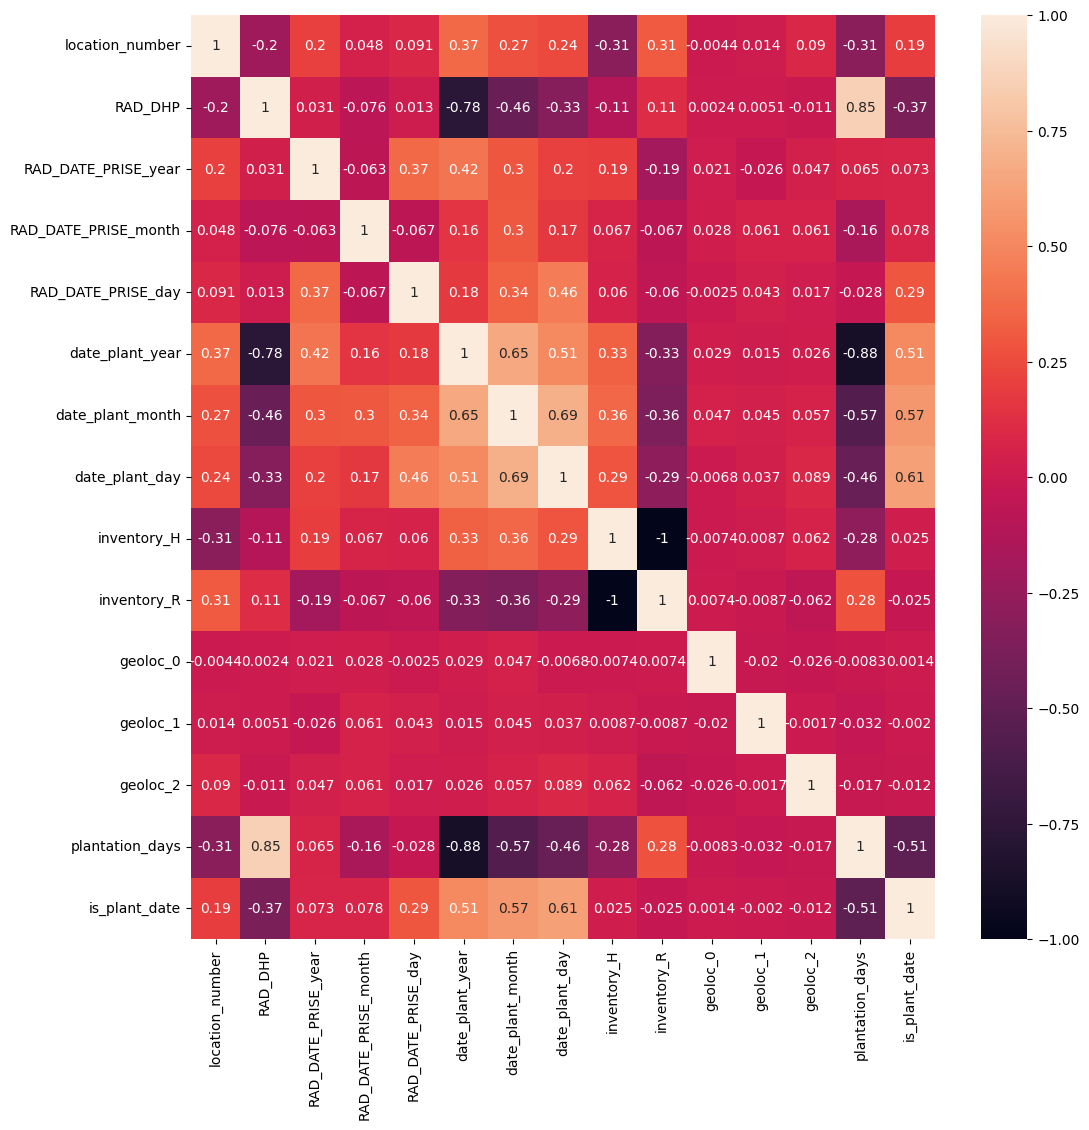

In [57]:
plt.figure(figsize=(12,12))
sns.heatmap(df_trees.corr(),annot=True)

In [58]:
df_trees["SIGLE"].value_counts().head(10)

ACPL      108059
FRPE       92452
ACSA       86907
TICO       47438
GLTR       36663
GLTRIN     21052
CEOC       18276
PIPU       12029
ULPU       11940
SYRE       10632
Name: SIGLE, dtype: int64

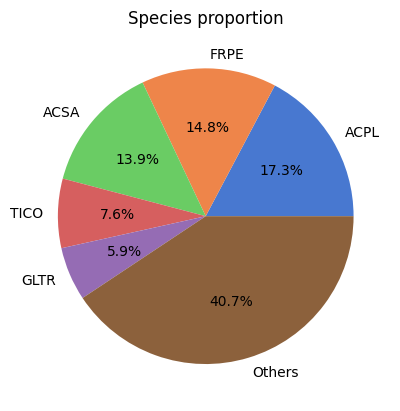

In [59]:
# Compter le nombre d'occurrences de chaque SIGLE--count the number of occurences of each acronyms
counts = df_trees['SIGLE'].value_counts()

# Définir un seuil pour les SIGLES minoritaires--define a threshold for minority acronyms
seuil = 30000

# Filtrer les SIGLES majoritaires--filter the maj acronyms
majoritaires = counts[counts >= seuil]

# Extraire les labels et les proportions des SIGLES majoritaires--extract the labels and proportions of majority
labels_majoritaires = majoritaires.index.tolist()
proportions_majoritaires = majoritaires.values.tolist()

# Extraire les labels et les proportions des SIGLES minoritaires--extract the labels and proportions of minority
labels_minoritaires = counts[counts < seuil].index.tolist()
proportions_minoritaires = counts[counts < seuil].values.tolist()

# Étiquette générique pour les SIGLES minoritaires--generic label for minority acronyms
generic_label = 'Others'

# Regrouper les proportions et les labels pour le pie chart--group proportions and labels for the pie chart
labels = labels_majoritaires + [generic_label]
proportions = proportions_majoritaires + [sum(proportions_minoritaires)]

# Créer un pie chart--create a pie chart
palette_colors = sns.color_palette('muted')
plt.pie(proportions, labels=labels, autopct=lambda p: f'{p:.1f}%' if p >= 5 else '', colors=palette_colors)

# Ajouter un titre--add title
plt.title('Species proportion')

# Afficher le pie chart-- show pie chart
plt.show()

The top 3 species with the most observations is "Erable de Norvège" (Acer platanoides - ACPL), "Erable argenté" (Acer saccharinum - ACSA) and "Frene de Pennsylvanie" (Fraxinus pennsylvanica - FRPE). So we will focus on these sepcies for the predictions.

In [60]:
df_trees[df_trees["SIGLE"] == "ACSA"].isna().sum()

location_number             0
RAD_DHP                     0
RAD_DATE_PRISE             82
specie_latin                0
SIGLE                       0
Genre                       0
Famille                     0
date_plant              61951
RAD_DATE_PRISE_year        82
RAD_DATE_PRISE_month       82
RAD_DATE_PRISE_day         82
date_plant_year         61951
date_plant_month        61951
date_plant_day          61951
inventory_H                 0
inventory_R                 0
geohash                     0
geoloc_0                    0
geoloc_1                    0
geoloc_2                    0
plantation_days         61951
is_plant_date               0
dtype: int64

Thanks to the heatmap of the correlation, the plantation date is the variable the most correlated to the DBH. But this is the variable with the highest number of missing values. A good way to impute would be to put a date prior the first DBH statement date of the concerned tree, or we could also try to impute these missing values with machine learning -> futur line of work

### Annual Growth

It's important to have an idea of the annual growth per species so that we would be able to know if our result of prediction is a good result or not. Basically, the larger the prediction's MAE and RMSE are compared to the annual growth of the species, the worst it is.

In [61]:
subset = df_trees.groupby(["SIGLE", "date_plant_year", "RAD_DATE_PRISE_year"])["RAD_DHP"].mean().reset_index(name="Average DBH")
subset["Gap"] = subset.groupby(["SIGLE", "date_plant_year"])["Average DBH"].diff()
# neg_growth  = subset[subset["Gap"] < 0]
# subset = subset.drop(neg_growth.index)
subset["Nb year between DBH intake"] = subset.groupby(["SIGLE", "date_plant_year"])["RAD_DATE_PRISE_year"].diff()
# subset
subset["Annual growth"] = subset["Gap"] / subset["Nb year between DBH intake"]
# subset
annual_growth_species = subset.groupby("SIGLE")["Annual growth"].mean().reset_index(name="Annual growth")
annual_growth_species

,SIGLE,Annual growth
0,ABBA,2.187951
1,ABCO,0.655139
2,ABKO,0.222222
3,ABSI,NaN
4,AC,1.184722
...,...,...
250,ULTH,0.950000
251,ULWI,1.026879
252,ULXX,0.740153
253,ULXXNH,0.000000


Some Annual growth are negative, it can be explained either by the fact that there as still outliers DBH values, or by the fact that trees are felled and so big DBH values soudainly disapears and so the Annual growth looks like decreasing. -> need more investigate but for now, removal of these values.

In [62]:
subset = annual_growth_species[annual_growth_species["Annual growth"] <= 0]
annual_growth_species = annual_growth_species.drop(subset.index)

Text(0.5, 1.0, 'Average annual diameter growth per species')

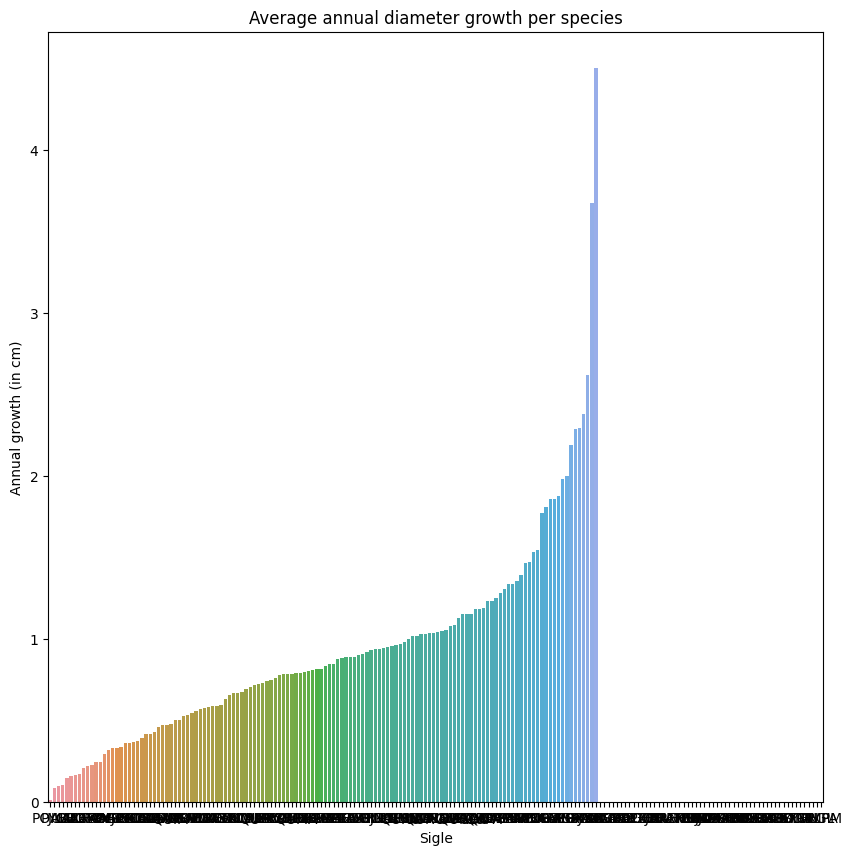

In [63]:
annual_growth_species = annual_growth_species.sort_values("Annual growth")
plt.figure(figsize=(10,10))
sns.barplot(data=annual_growth_species, x=annual_growth_species["SIGLE"], y=annual_growth_species["Annual growth"])
plt.ylabel("Annual growth (in cm)")
plt.xlabel("Sigle")
plt.title("Average annual diameter growth per species")

Text(0.5, 1.0, 'Average annual diameter growth of top 3 most present species')

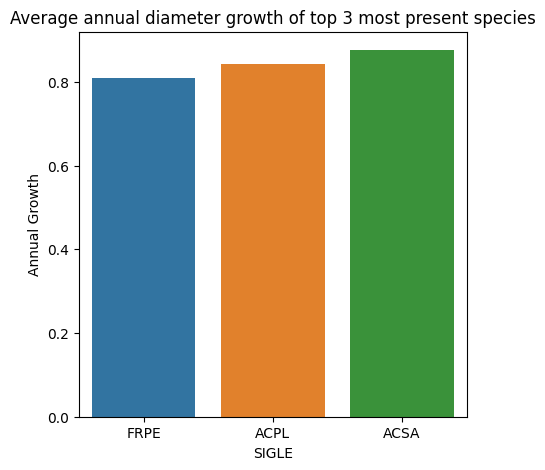

In [64]:
plt.figure(figsize=(5,5))
top3 = annual_growth_species.query("(SIGLE == 'ACPL') | (SIGLE == 'ACSA') | (SIGLE == 'FRPE')")
sns.barplot(data=top3, x=top3["SIGLE"], y=top3["Annual growth"])
plt.ylabel("Annual Growth")
plt.title("Average annual diameter growth of top 3 most present species")

In [65]:
annual_growth_species["Annual growth"].mean()

0.9303765219522936

In [66]:
annual_growth_species[annual_growth_species["SIGLE"] == "ACSA"]

,SIGLE,Annual growth
20,ACSA,0.87603


In [67]:
annual_growth_species.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 166 to 246
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SIGLE          186 non-null    object 
 1   Annual growth  132 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.4+ KB


I add species name to the annual growth df for better analysis :

In [68]:
# Function to cut off Species if necessary
def modify_species(row):
    if "'" in row['specie_latin']:
        return row['specie_latin'].split("'")[0]
    else:
        return row['specie_latin']

df_trees["Species"] = df_trees.apply(modify_species, axis=1)
df_trees.reset_index(drop=True, inplace=True)
df_trees

,location_number,RAD_DHP,RAD_DATE_PRISE,specie_latin,SIGLE,Genre,Famille,date_plant,RAD_DATE_PRISE_year,RAD_DATE_PRISE_month,...,date_plant_day,inventory_H,inventory_R,geohash,geoloc_0,geoloc_1,geoloc_2,plantation_days,is_plant_date,Species
0,2,5,2004-06-16,Acer platanoides 'Columnare',ACPL,Acer,Sapindaceae,2004-06-16,2004.0,6.0,...,16.0,1,0,f25dv,0.0,0.0,-1.0,0.0,True,Acer platanoides
1,6,25,2018-06-26,Gleditsia triacanthos 'Skyline',GLTR,Gleditsia,Fabaceae,2004-10-06,2018.0,6.0,...,6.0,1,0,f25e4,1.0,0.0,0.0,5011.0,False,Gleditsia triacanthos
2,7,32,2018-06-27,Gleditsia triacanthos 'Skyline',GLTR,Gleditsia,Fabaceae,2004-06-18,2018.0,6.0,...,18.0,1,0,f25e4,1.0,0.0,0.0,5122.0,False,Gleditsia triacanthos
3,9,5,2018-07-12,Fraxinus nigra 'Fall Gold',FRNI,Fraxinus,Oleaceae,2004-06-18,2018.0,7.0,...,18.0,1,0,f25e4,1.0,0.0,0.0,5137.0,False,Fraxinus nigra
4,10,34,2018-06-27,Quercus rubra,QURU,Quercus,Fagaceae,2004-06-18,2018.0,6.0,...,18.0,1,0,f25e4,1.0,0.0,0.0,5122.0,False,Quercus rubra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626137,596685,5,2022-11-11,Aesculus hippocastanum 'Baumanii',AEHI,Aesculus,Sapindaceae,2022-11-11,2022.0,11.0,...,11.0,0,1,f25dk,0.0,0.0,1.0,0.0,True,Aesculus hippocastanum
626138,596785,34,2023-05-03,Populus,PO,NaN,NaN,NaT,2023.0,5.0,...,NaN,0,1,f25et,-1.0,0.0,0.0,NaN,False,Populus
626139,596785,30,2023-05-03,Populus,PO,NaN,NaN,NaT,2023.0,5.0,...,NaN,0,1,f25et,-1.0,0.0,0.0,NaN,False,Populus
626140,596805,52,2023-05-03,Populus,PO,NaN,NaN,NaT,2023.0,5.0,...,NaN,0,1,f25et,-1.0,0.0,0.0,NaN,False,Populus


In [69]:
annual_growth_test = pd.merge(annual_growth_species, df_trees[["SIGLE", "Species"]], on="SIGLE", how="left")
annual_growth_test

,SIGLE,Annual growth,Species
0,POAL,0.011111,Populus alba
1,POAL,0.011111,Populus alba
2,POAL,0.011111,Populus alba
3,POAL,0.011111,Populus alba
4,POAL,0.011111,Populus alba
...,...,...,...
588228,ULPA,NaN,Ulmus parvifolia
588229,ULPA,NaN,Ulmus parvifolia
588230,ULPA,NaN,Ulmus parvifolia
588231,ULPA,NaN,Ulmus parvifolia


In [70]:
# There are duplicates I didn't succed to remove but ok because it is just to analyse the coherence of the annual growth by Annick
test = annual_growth_test.drop_duplicates()
test.to_csv(r'./Annual_growth_per_species.csv', index=False)

In [71]:
df_trees_annual_growth = df_trees.merge(annual_growth_species, how="left", on="SIGLE")
df_trees_annual_growth = df_trees_annual_growth.drop(["location_number", "RAD_DATE_PRISE","specie_latin","date_plant", "Famille", "Genre", "geohash", "Species"], axis=1)
df_trees_annual_growth

,RAD_DHP,SIGLE,RAD_DATE_PRISE_year,RAD_DATE_PRISE_month,RAD_DATE_PRISE_day,date_plant_year,date_plant_month,date_plant_day,inventory_H,inventory_R,geoloc_0,geoloc_1,geoloc_2,plantation_days,is_plant_date,Annual growth
0,5,ACPL,2004.0,6.0,16.0,2004.0,6.0,16.0,1,0,0.0,0.0,-1.0,0.0,True,0.842074
1,25,GLTR,2018.0,6.0,26.0,2004.0,10.0,6.0,1,0,1.0,0.0,0.0,5011.0,False,0.898376
2,32,GLTR,2018.0,6.0,27.0,2004.0,6.0,18.0,1,0,1.0,0.0,0.0,5122.0,False,0.898376
3,5,FRNI,2018.0,7.0,12.0,2004.0,6.0,18.0,1,0,1.0,0.0,0.0,5137.0,False,1.463611
4,34,QURU,2018.0,6.0,27.0,2004.0,6.0,18.0,1,0,1.0,0.0,0.0,5122.0,False,0.964919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626137,5,AEHI,2022.0,11.0,11.0,2022.0,11.0,11.0,0,1,0.0,0.0,1.0,0.0,True,1.042251
626138,34,PO,2023.0,5.0,3.0,NaN,NaN,NaN,0,1,-1.0,0.0,0.0,NaN,False,1.150000
626139,30,PO,2023.0,5.0,3.0,NaN,NaN,NaN,0,1,-1.0,0.0,0.0,NaN,False,1.150000
626140,52,PO,2023.0,5.0,3.0,NaN,NaN,NaN,0,1,-1.0,0.0,0.0,NaN,False,1.150000


In [72]:
df_trees_annual_growth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626142 entries, 0 to 626141
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   RAD_DHP               626142 non-null  int64  
 1   SIGLE                 626142 non-null  object 
 2   RAD_DATE_PRISE_year   625910 non-null  float64
 3   RAD_DATE_PRISE_month  625910 non-null  float64
 4   RAD_DATE_PRISE_day    625910 non-null  float64
 5   date_plant_year       309868 non-null  float64
 6   date_plant_month      309868 non-null  float64
 7   date_plant_day        309868 non-null  float64
 8   inventory_H           626142 non-null  uint8  
 9   inventory_R           626142 non-null  uint8  
 10  geoloc_0              626142 non-null  float64
 11  geoloc_1              626142 non-null  float64
 12  geoloc_2              626142 non-null  float64
 13  plantation_days       309868 non-null  float64
 14  is_plant_date         626142 non-null  bool   
 15  

<ipython-input-73-cb53692fb436>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_trees_annual_growth.corr(),annot=True)


<Axes: >

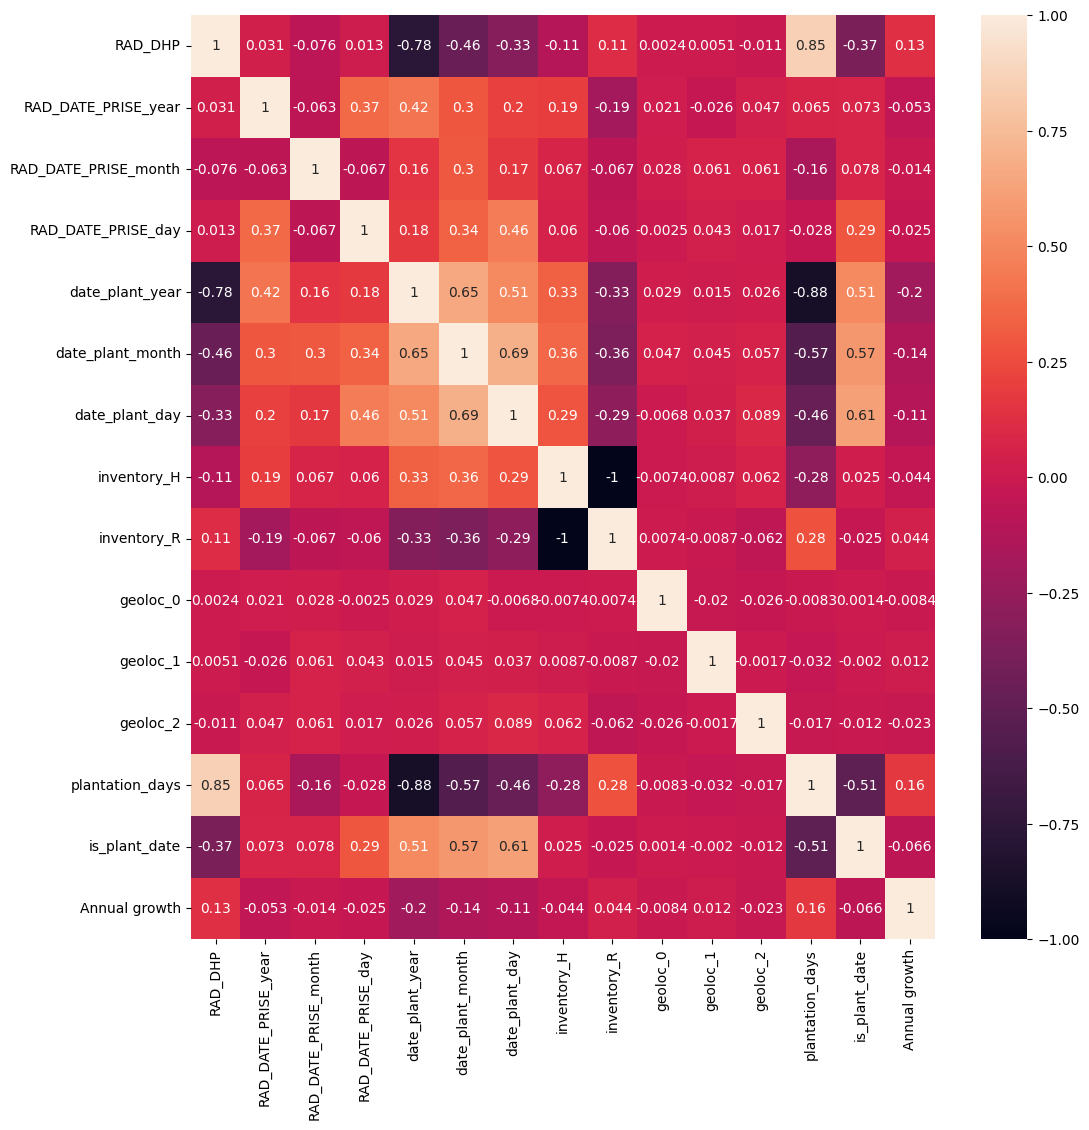

In [73]:
plt.figure(figsize=(12,12))
sns.heatmap(df_trees_annual_growth.corr(),annot=True)

## Preprocessing

### Removal of useless columns

In [74]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626142 entries, 0 to 626141
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   location_number       626142 non-null  int64         
 1   RAD_DHP               626142 non-null  int64         
 2   RAD_DATE_PRISE        625910 non-null  datetime64[ns]
 3   specie_latin          626142 non-null  object        
 4   SIGLE                 626142 non-null  object        
 5   Genre                 622017 non-null  object        
 6   Famille               622017 non-null  object        
 7   date_plant            309868 non-null  datetime64[ns]
 8   RAD_DATE_PRISE_year   625910 non-null  float64       
 9   RAD_DATE_PRISE_month  625910 non-null  float64       
 10  RAD_DATE_PRISE_day    625910 non-null  float64       
 11  date_plant_year       309868 non-null  float64       
 12  date_plant_month      309868 non-null  float64       
 13 

In [75]:
df_trees = df_trees.drop([ "location_number", "RAD_DATE_PRISE", "specie_latin", "date_plant", "Famille", "Genre", "geohash", "Species"], axis=1)

In [76]:
df_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626142 entries, 0 to 626141
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   RAD_DHP               626142 non-null  int64  
 1   SIGLE                 626142 non-null  object 
 2   RAD_DATE_PRISE_year   625910 non-null  float64
 3   RAD_DATE_PRISE_month  625910 non-null  float64
 4   RAD_DATE_PRISE_day    625910 non-null  float64
 5   date_plant_year       309868 non-null  float64
 6   date_plant_month      309868 non-null  float64
 7   date_plant_day        309868 non-null  float64
 8   inventory_H           626142 non-null  uint8  
 9   inventory_R           626142 non-null  uint8  
 10  geoloc_0              626142 non-null  float64
 11  geoloc_1              626142 non-null  float64
 12  geoloc_2              626142 non-null  float64
 13  plantation_days       309868 non-null  float64
 14  is_plant_date         626142 non-null  bool   
dtype

### Dataset split for top3 species

In [77]:
acpl_df = df_trees.query("SIGLE == 'ACPL'")
acsa_df = df_trees.query("SIGLE == 'ACSA'")
frpe_df = df_trees.query("SIGLE == 'FRPE'")

In [78]:
acpl_df = acpl_df.drop("SIGLE", axis=1)
acsa_df = acsa_df.drop("SIGLE", axis=1)
frpe_df = frpe_df.drop("SIGLE", axis=1)

In [79]:
acpl_df

,RAD_DHP,RAD_DATE_PRISE_year,RAD_DATE_PRISE_month,RAD_DATE_PRISE_day,date_plant_year,date_plant_month,date_plant_day,inventory_H,inventory_R,geoloc_0,geoloc_1,geoloc_2,plantation_days,is_plant_date
0,5,2004.0,6.0,16.0,2004.0,6.0,16.0,1,0,0.0,0.0,-1.0,0.0,True
7,34,2018.0,6.0,27.0,2004.0,6.0,18.0,1,0,1.0,0.0,0.0,5122.0,False
34,18,2014.0,1.0,29.0,2004.0,12.0,7.0,1,0,-1.0,0.0,0.0,3340.0,False
35,27,2018.0,7.0,13.0,2004.0,12.0,7.0,1,0,-1.0,0.0,0.0,4966.0,False
36,17,2014.0,1.0,29.0,2004.0,12.0,7.0,1,0,-1.0,0.0,0.0,3340.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625850,10,2022.0,7.0,14.0,NaN,NaN,NaN,0,1,0.0,0.0,1.0,NaN,False
625870,39,2022.0,7.0,15.0,NaN,NaN,NaN,0,1,0.0,0.0,1.0,NaN,False
625933,5,2023.0,4.0,25.0,2023.0,4.0,25.0,0,1,0.0,-1.0,0.0,0.0,True
626130,13,2023.0,4.0,20.0,NaN,NaN,NaN,0,1,-1.0,0.0,0.0,NaN,False


### Removal of missing values

In [80]:
subset = acpl_df[acpl_df["date_plant_year"].isna()]
acpl_df = acpl_df.drop(subset.index)
acpl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52367 entries, 0 to 625933
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RAD_DHP               52367 non-null  int64  
 1   RAD_DATE_PRISE_year   52367 non-null  float64
 2   RAD_DATE_PRISE_month  52367 non-null  float64
 3   RAD_DATE_PRISE_day    52367 non-null  float64
 4   date_plant_year       52367 non-null  float64
 5   date_plant_month      52367 non-null  float64
 6   date_plant_day        52367 non-null  float64
 7   inventory_H           52367 non-null  uint8  
 8   inventory_R           52367 non-null  uint8  
 9   geoloc_0              52367 non-null  float64
 10  geoloc_1              52367 non-null  float64
 11  geoloc_2              52367 non-null  float64
 12  plantation_days       52367 non-null  float64
 13  is_plant_date         52367 non-null  bool   
dtypes: bool(1), float64(10), int64(1), uint8(2)
memory usage: 4.9 MB


In [81]:
acsa_df_nan_val = acsa_df # Will be usefull later to try to impute plantation date
subset = acsa_df[acsa_df["date_plant_year"].isna()]
acsa_df = acsa_df.drop(subset.index)
acsa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24956 entries, 6 to 625823
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RAD_DHP               24956 non-null  int64  
 1   RAD_DATE_PRISE_year   24956 non-null  float64
 2   RAD_DATE_PRISE_month  24956 non-null  float64
 3   RAD_DATE_PRISE_day    24956 non-null  float64
 4   date_plant_year       24956 non-null  float64
 5   date_plant_month      24956 non-null  float64
 6   date_plant_day        24956 non-null  float64
 7   inventory_H           24956 non-null  uint8  
 8   inventory_R           24956 non-null  uint8  
 9   geoloc_0              24956 non-null  float64
 10  geoloc_1              24956 non-null  float64
 11  geoloc_2              24956 non-null  float64
 12  plantation_days       24956 non-null  float64
 13  is_plant_date         24956 non-null  bool   
dtypes: bool(1), float64(10), int64(1), uint8(2)
memory usage: 2.4 MB


In [82]:
subset = frpe_df[frpe_df["date_plant_year"].isna()]
frpe_df = frpe_df.drop(subset.index)
frpe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51670 entries, 432 to 623240
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RAD_DHP               51670 non-null  int64  
 1   RAD_DATE_PRISE_year   51670 non-null  float64
 2   RAD_DATE_PRISE_month  51670 non-null  float64
 3   RAD_DATE_PRISE_day    51670 non-null  float64
 4   date_plant_year       51670 non-null  float64
 5   date_plant_month      51670 non-null  float64
 6   date_plant_day        51670 non-null  float64
 7   inventory_H           51670 non-null  uint8  
 8   inventory_R           51670 non-null  uint8  
 9   geoloc_0              51670 non-null  float64
 10  geoloc_1              51670 non-null  float64
 11  geoloc_2              51670 non-null  float64
 12  plantation_days       51670 non-null  float64
 13  is_plant_date         51670 non-null  bool   
dtypes: bool(1), float64(10), int64(1), uint8(2)
memory usage: 4.9 MB


## Processing test 1 : with the removal of missing date plantation

### Species 1 : ACPL

<Axes: >

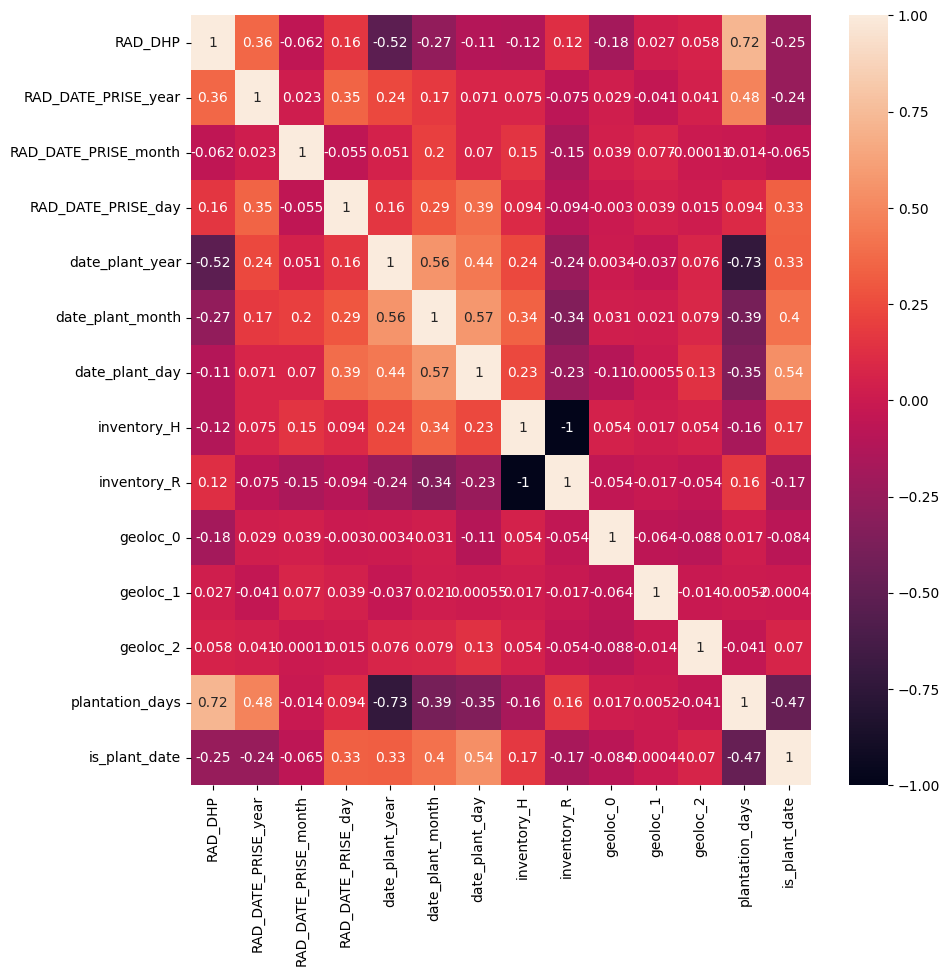

In [83]:
plt.figure(figsize=(10,10))
sns.heatmap(data=acpl_df.corr(), annot=True)

In [84]:
acpl_x_df = acpl_df.drop("RAD_DHP", axis=1)
acpl_target = acpl_df["RAD_DHP"]

# Normalizing
scaler = MinMaxScaler()
acpl_x_df = scaler.fit_transform(acpl_x_df)

X_train, X_test, y_train, y_test = train_test_split(acpl_x_df, acpl_target, test_size=0.2, shuffle=True, random_state=42)


In [85]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



### Linear Regression :

In [86]:
#Training linear regresssion
regr = LinearRegression()
model = regr.fit(X_train, y_train)

#Linear regression predictions
y_pred = model.predict(X_test)
print(regr.score(X_test, y_test))

0.5623677131803355


In [87]:
metrics.mean_squared_error(y_test, y_pred, squared=False)

11.056530292996955

In [88]:
mean_absolute_error(y_test, y_pred)

7.734251173759811

#### Linear Regression with CV

In [89]:
#evaluation using cross validation
def linear_regression_cv(train_data_x, train_data_y):
    model = LinearRegression()
    scores = cross_val_score(model, train_data_x, train_data_y, cv=5, scoring= make_scorer(metrics.mean_squared_error, squared=False))
    rmse_scores = scores
    return rmse_scores



In [90]:
rmse_scores = linear_regression_cv(X_train, y_train)
print('Cross-validation RMSE scores:', rmse_scores)
print('Mean RMSE score:', rmse_scores.mean())
# Evaluate the model on the training set
train_predictions = model.predict(X_train)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
print('Training set RMSE:', train_rmse)


# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
print('Test set RMSE:', test_rmse)


Cross-validation RMSE scores: [10.85851438 10.65681473 10.68143138 10.32962862 10.49484706]
Mean RMSE score: 10.604247234760056
Training set RMSE: 10.59780672272359
Test set RMSE: 11.056530292996955


#### Randomized and Grid Search CV on LR

In [91]:
def linear_regression_grid_search(train_data_x, train_data_y):
    model = LinearRegression()
    param_grid = {'fit_intercept': [True, False], 'positive': [True, False]}
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring= make_scorer(metrics.mean_squared_error, squared=False))
    grid_search.fit(train_data_x, train_data_y)
    return grid_search


def linear_regression_randomized_search(train_data_x, train_data_y):
    model = LinearRegression(copy_X=False)
    param_distributions = {'fit_intercept': [True, False], 'positive': [True, False],
                           'copy_X': [True, False], 'n_jobs': [1, 2, 3, 4, -1]}
    random_search = RandomizedSearchCV(model, param_distributions, cv=5, scoring=make_scorer(metrics.mean_squared_error, squared=False), n_iter=20)
    random_search.fit(train_data_x, train_data_y)
    return random_search

# Train a linear regression model using grid search and cross-validation
grid_search = linear_regression_grid_search(X_train, y_train)

print('Best parameters (grid search):', grid_search.best_params_)
print('Best score (grid search):', grid_search.best_score_)


# Train a linear regression model using randomized search and cross-validation
random_search = linear_regression_randomized_search(X_train, y_train)
print('Best parameters (randomized search):', random_search.best_params_)
print('Best score (randomized search):', random_search.best_score_)

# Evaluate the models on the training set
train_predictions_cv = grid_search.best_estimator_.predict(X_train)
train_rmse_cv = mean_squared_error(y_train, train_predictions_cv, squared=False)
print('Training set RMSE (cross-validation):', train_rmse_cv)



train_predictions_gs = grid_search.best_estimator_.predict(X_train)
train_rmse_gs = mean_squared_error(y_train, train_predictions_gs, squared=False)
print('Training set RMSE (grid search):', train_rmse_gs)




train_predictions_rs = random_search.best_estimator_.predict(X_train)
train_rmse_rs = mean_squared_error(y_train, train_predictions_rs, squared=False)
print('Training set RMSE (randomized search):', train_rmse_rs)


# Evaluate the models on the test set
test_predictions_cv = grid_search.best_estimator_.predict(X_test)
test_rmse_cv = mean_squared_error(y_test, test_predictions_cv, squared=False)
print('Test set RMSE (cross-validation):', test_rmse_cv)




test_predictions_gs = grid_search.best_estimator_.predict(X_test)
test_rmse_gs = mean_squared_error(y_test, test_predictions_gs, squared=False)
print('Test set RMSE (grid search):', test_rmse_gs)




test_predictions_rs = random_search.best_estimator_.predict(X_test)
test_rmse_rs = mean_squared_error(y_test, test_predictions_rs, squared=False)
print('Test set RMSE (randomized search):', test_rmse_rs)




Best parameters (grid search): {'fit_intercept': False, 'positive': True}
Best score (grid search): 11.055452894438663
Best parameters (randomized search): {'positive': True, 'n_jobs': 3, 'fit_intercept': False, 'copy_X': True}
Best score (randomized search): 11.055452894438663
Training set RMSE (cross-validation): 11.05037814136592
Training set RMSE (grid search): 11.05037814136592
Training set RMSE (randomized search): 11.05037814136592
Test set RMSE (cross-validation): 11.470900440786158
Test set RMSE (grid search): 11.470900440786158
Test set RMSE (randomized search): 11.470900440786158


###Random Forest :

In [92]:
regr = RandomForestRegressor(random_state=42)
regr.fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)

In [93]:
compute_error(y_pred_rf, y_test)

Mean Absolute Error: 4.218950110428155
Mean Squared Error: 45.37468819926094
Root Mean Squared Error: 6.7360736485924
Accuracy (r2 score): 0.8113582990803195


In [94]:
pprint(regr.get_params())

Pretty printing has been turned OFF


In [95]:
application_cross_val(model=RandomForestRegressor(n_estimators = 100, random_state=42), X=X_train, y=y_train)

Scores de validation croisée - MAE:
[4.20310468 4.16034766 4.18809804 4.11304259 4.17741836]
MAE moyen :  4.168402265191004

Scores de validation croisée - MSE:
[45.0930393  44.58260324 44.10514682 43.46665305 44.65745324]
MSE moyen :  44.38097913137763

Scores de validation croisée - RMSE:
[6.71513509 6.67702054 6.64117059 6.59292447 6.68262323]
RMSE moyen :  6.661774783721495

Scores de validation croisée - R2:
[0.83426823 0.83587681 0.84353809 0.83813984 0.84060412]
R2 moyen :  0.8384854183162277


In [96]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


#### Randomized Search CV on RF

In [97]:
#Applying Randomized search CV on RF for making predictions
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [98]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [99]:
rf_random.best_params_

{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

In [100]:
best_random = rf_random.best_estimator_
predictions = best_random.predict(X_test)

In [101]:
compute_error(predictions, y_test)

Mean Absolute Error: 4.147182121470778
Mean Squared Error: 42.921737366769705
Root Mean Squared Error: 6.551468336699011
Accuracy (r2 score): 0.8154783519677673


#### Grid Search CV on RF

In [102]:
# Applying GridSearchCV on RF for predictions
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 30, 40, 50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [600, 700, 800, 900, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [103]:
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 180 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [20, 30, 40, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [600, 700, 800, 900, 1000]},
             verbose=2)

In [104]:
grid_search.best_params_

{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1000}

In [105]:
best_grid = grid_search.best_estimator_
predictions_grid = best_grid.predict(X_test)

In [106]:
compute_error(predictions_grid, y_test)

Mean Absolute Error: 4.122088855488708
Mean Squared Error: 42.76666596012496
Root Mean Squared Error: 6.539622768946613
Accuracy (r2 score): 0.8177296768560474


### Species 2 : ACSA (Erable Argenté)

According to Annick, it is better to work with ACSA because this species have less DBH variations between cultivars, so the result should be better.

<Axes: >

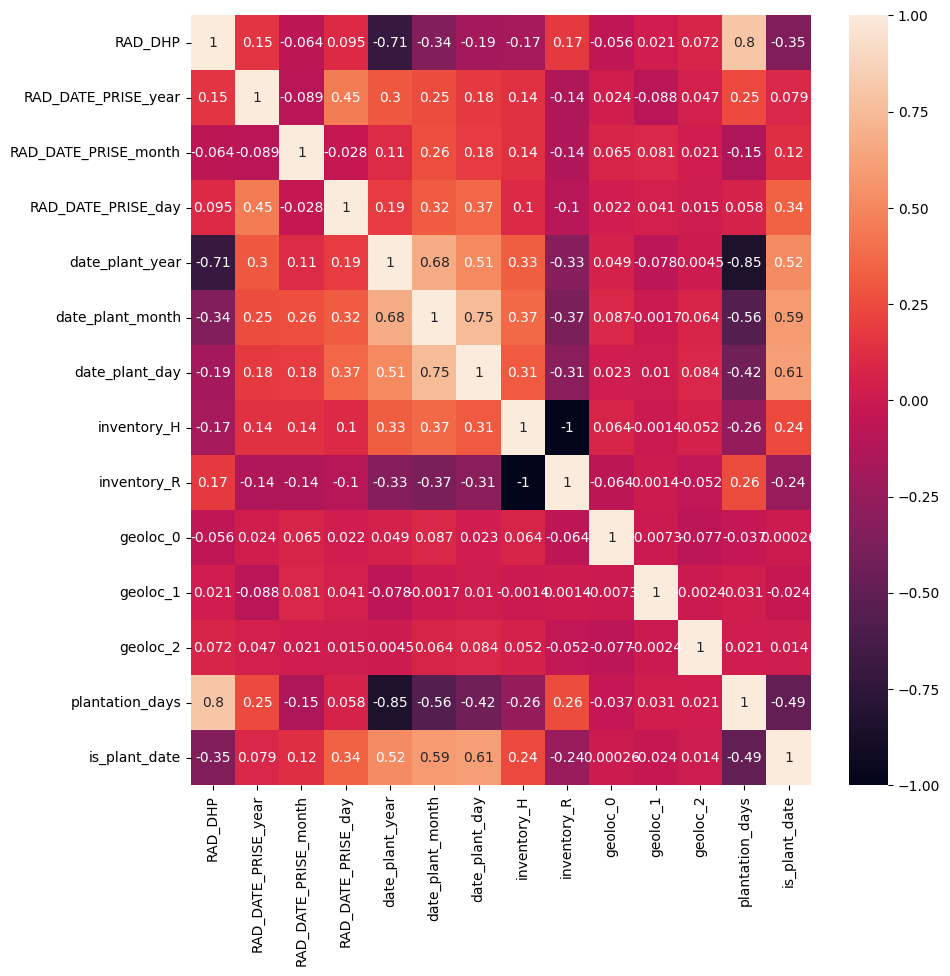

In [107]:
plt.figure(figsize=(10,10))
sns.heatmap(data=acsa_df.corr(), annot=True)

In [108]:
acsa_target = acsa_df["RAD_DHP"]
acsa_x_df = acsa_df.drop("RAD_DHP", axis=1)

# Normalizing
scaler = MinMaxScaler()
acsa_x_df = scaler.fit_transform(acsa_x_df)

In [109]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(acsa_x_df, acsa_target, test_size=0.2, shuffle=True, random_state=42)

### Linear Regression

In [110]:
#Training linear regresssion
regr = LinearRegression()
model = regr.fit(X_train_1, y_train_1)

#Linear regression predictions
y_pred = model.predict(X_test_1)
print(regr.score(X_test_1, y_test_1))

0.7036364474896417


In [111]:
metrics.mean_squared_error(y_test_1, y_pred, squared=False)



11.54383143458232

In [112]:
mean_absolute_error(y_test_1, y_pred)

8.342378268353045

####Linear Regression with CV

In [113]:
#evaluation using cross validation
def linear_regression_cv(train_data_x, train_data_y):
  model = LinearRegression()
  scores = cross_val_score(model, train_data_x, train_data_y, cv=5, scoring= make_scorer(metrics.mean_squared_error, squared=False))
  rmse_scores = scores
  return rmse_scores

rmse_scores = linear_regression_cv(X_train_1, y_train_1)
print('Cross-validation RMSE scores:', rmse_scores)
print('Mean RMSE score:', rmse_scores.mean())


Cross-validation RMSE scores: [11.79172987 11.8293386  12.14273524 11.7139815  11.93038073]
Mean RMSE score: 11.881633187011795


In [114]:
# Evaluate the model on the training set
train_predictions = model.predict(X_train_1)
train_rmse = mean_squared_error(y_train_1, train_predictions, squared=False)
print('Training set RMSE:', train_rmse)


# Evaluate the model on the test set
test_predictions = model.predict(X_test_1)
test_rmse = mean_squared_error(y_test_1, test_predictions, squared=False)
print('Test set RMSE:', test_rmse)

Training set RMSE: 11.872783541311799
Test set RMSE: 11.54383143458232


#### Grid Search and Randomized Search CV on LR

In [115]:
def linear_regression_grid_search(train_data_x, train_data_y):
    model = LinearRegression()
    param_grid = {'fit_intercept': [True, False], 'positive': [True, False]}
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring= make_scorer(metrics.mean_squared_error, squared=False))
    grid_search.fit(train_data_x, train_data_y)
    return grid_search


def linear_regression_randomized_search(train_data_x, train_data_y):
    model = LinearRegression(copy_X=False)
    param_distributions = {'fit_intercept': [True, False], 'positive': [True, False],
                           'copy_X': [True, False], 'n_jobs': [1, 2, 3, 4, -1]}
    random_search = RandomizedSearchCV(model, param_distributions, cv=5, scoring=make_scorer(metrics.mean_squared_error, squared=False), n_iter=20)
    random_search.fit(train_data_x, train_data_y)
    return random_search

# Train a linear regression model using grid search and cross-validation
grid_search = linear_regression_grid_search(X_train_1, y_train_1)

print('Best parameters (grid search):', grid_search.best_params_)
print('Best score (grid search):', grid_search.best_score_)


# Train a linear regression model using randomized search and cross-validation
random_search = linear_regression_randomized_search(X_train_1, y_train_1)
print('Best parameters (randomized search):', random_search.best_params_)
print('Best score (randomized search):', random_search.best_score_)

# Evaluate the models on the training set
train_predictions_cv = grid_search.best_estimator_.predict(X_train_1)
train_rmse_cv = mean_squared_error(y_train_1, train_predictions_cv, squared=False)
print('Training set RMSE (cross-validation):', train_rmse_cv)



train_predictions_gs = grid_search.best_estimator_.predict(X_train_1)
train_rmse_gs = mean_squared_error(y_train_1, train_predictions_gs, squared=False)
print('Training set RMSE (grid search):', train_rmse_gs)




train_predictions_rs = random_search.best_estimator_.predict(X_train_1)
train_rmse_rs = mean_squared_error(y_train_1, train_predictions_rs, squared=False)
print('Training set RMSE (randomized search):', train_rmse_rs)


# Evaluate the models on the test set
test_predictions_cv = grid_search.best_estimator_.predict(X_test_1)
test_rmse_cv = mean_squared_error(y_test_1, test_predictions_cv, squared=False)
print('Test set RMSE (cross-validation):', test_rmse_cv)




test_predictions_gs = grid_search.best_estimator_.predict(X_test_1)
test_rmse_gs = mean_squared_error(y_test_1, test_predictions_gs, squared=False)
print('Test set RMSE (grid search):', test_rmse_gs)




test_predictions_rs = random_search.best_estimator_.predict(X_test_1)
test_rmse_rs = mean_squared_error(y_test_1, test_predictions_rs, squared=False)
print('Test set RMSE (randomized search):', test_rmse_rs)




Best parameters (grid search): {'fit_intercept': True, 'positive': True}
Best score (grid search): 12.222463160662413
Best parameters (randomized search): {'positive': True, 'n_jobs': 3, 'fit_intercept': True, 'copy_X': False}
Best score (randomized search): 12.222463160662413
Training set RMSE (cross-validation): 34.20210098986801
Training set RMSE (grid search): 34.20210098986801
Training set RMSE (randomized search): 34.20210098986801
Test set RMSE (cross-validation): 11.8639049637753
Test set RMSE (grid search): 11.8639049637753
Test set RMSE (randomized search): 11.8639049637753


### Random forest


In [116]:
regr = RandomForestRegressor(random_state=42)
regr.fit(X_train_1, y_train_1)
y_pred_rf = regr.predict(X_test_1)

In [117]:
compute_error(y_pred_rf, y_test_1)
application_cross_val(model=RandomForestRegressor(n_estimators = 100, random_state=42), X=X_train_1, y=y_train_1)

Mean Absolute Error: 27.32188214138906
Mean Squared Error: 939.6322590207382
Root Mean Squared Error: 30.65342165274112
Accuracy (r2 score): -2.860326448865276
Scores de validation croisée - MAE:
[6.18462506 6.21361058 6.31859885 6.38346443 6.26571781]
MAE moyen :  6.273203346851819

Scores de validation croisée - MSE:
[86.77616087 93.93446535 93.56424269 96.87715389 93.78839775]
MSE moyen :  92.98808410993772

Scores de validation croisée - RMSE:
[9.31537229 9.69197943 9.67286114 9.84261926 9.68444101]
RMSE moyen :  9.641454627739616

Scores de validation croisée - R2:
[0.80584211 0.78928895 0.79422439 0.78401845 0.79699909]
R2 moyen :  0.794074596659238


In [118]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


####Randomized search cv on rf

In [119]:
#Applying Randomized search CV on RF for making predictions
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [120]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_1, y_train_1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [121]:
rf_random.best_params_

{'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

In [122]:
best_random = rf_random.best_estimator_
predictions = best_random.predict(X_test_1)

In [123]:
compute_error(predictions, y_test_1)

Mean Absolute Error: 14.312923880281268
Mean Squared Error: 297.13734101054723
Root Mean Squared Error: 17.237672145929313
Accuracy (r2 score): -3.374969209310261


####Grid Search CV on rf

In [124]:
# Applying GridSearchCV on RF for predictions
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
'bootstrap': [False],
'max_depth': [20, 30, 40, 50],
'max_features': ['sqrt'],
'min_samples_leaf': [2, 3, 4],
'min_samples_split': [8, 10, 12],
'n_estimators': [600, 700, 800, 900, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
cv = 3, n_jobs = -1, verbose = 2)


In [125]:
grid_search.fit(X_train_1, y_train_1)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [20, 30, 40, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [600, 700, 800, 900, 1000]},
             verbose=2)

In [126]:
grid_search.best_params_




{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 1000}

In [127]:

best_grid = grid_search.best_estimator_
predictions_grid = best_grid.predict(X_test_1)

In [128]:
compute_error(predictions_grid, y_test_1)

Mean Absolute Error: 14.059187552667282
Mean Squared Error: 286.3885963904374
Root Mean Squared Error: 16.923019718431974
Accuracy (r2 score): -3.2348671961829254


###Neural Network

In [129]:
from tensorflow import keras

In [130]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.5 MB/s eta 0:00:00


In [131]:
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import keras_tuner

<ipython-input-131-f4a31b5ad43b>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [150]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),loss=root_mean_squared_error, metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

In [151]:
tuner = RandomSearch(
    build_model,
    objective= keras_tuner.Objective("val_rmse", direction= "min"),
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='DBH prediction1')

In [152]:
tuner.search(X_train_1, y_train_1,
             epochs=5,
             validation_data=(X_test_1, y_test_1))

Trial 5 Complete [00h 00m 47s]
val_rmse: 14.194819768269857

Best val_rmse So Far: 14.194819768269857
Total elapsed time: 00h 04m 45s


In [153]:
tuner.results_summary()

Results summary
Results in project/DBH prediction1
Showing 10 best trials
Objective(name="val_rmse", direction="min")

Trial 4 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 416
learning_rate: 0.01
units_2: 320
units_3: 448
units_4: 32
units_5: 320
units_6: 448
units_7: 256
units_8: 128
units_9: 384
Score: 14.194819768269857

Trial 3 summary
Hyperparameters:
num_layers: 2
units_0: 416
units_1: 192
learning_rate: 0.0001
units_2: 128
units_3: 384
units_4: 480
units_5: 352
units_6: 384
units_7: 64
units_8: 96
units_9: 512
Score: 17.304935455322266

Trial 0 summary
Hyperparameters:
num_layers: 9
units_0: 160
units_1: 512
learning_rate: 0.0001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
Score: 23.782236099243164

Trial 1 summary
Hyperparameters:
num_layers: 6
units_0: 128
units_1: 416
learning_rate: 0.0001
units_2: 320
units_3: 288
units_4: 384
units_5: 160
units_6: 96
units_7: 352
units_8: 160
Score: 32.81155967712402

Trial 2 summary
Hy

In [141]:
#model with no dropouts
def build_model(hp):
    model = keras.Sequential()
    counter=0
    for i in range(hp.Int('num_layers', 1, 10)):
      if counter==0:
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),activation= hp.Choice('activation'+ str(i), values=['relu', 'tanh','sigmoid']), input_dim= 13))
      else:
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation= hp.Choice('activation'+ str(i), values=['relu', 'tanh','sigmoid'])))
      counter+=1

    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=(hp.Choice('optimizer', values=['rmsprop', 'adam', 'sgd','nadam','adadelta'])),
           loss=root_mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

In [142]:
tuner = RandomSearch(
    build_model,
    objective= keras_tuner.Objective("val_rmse", direction= "min"),
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='DBH prediction2')

In [143]:
tuner.search(X_train_1, y_train_1,
             epochs=5,
             validation_data=(X_test_1, y_test_1))

In [144]:
tuner.results_summary()

Results summary
Results in project/DBH prediction2
Showing 10 best trials
Objective(name="val_rmse", direction="min")

Trial 0 summary
Hyperparameters:
num_layers: 2
units_0: 416
activation0: tanh
optimizer: sgd
units_1: 32
activation1: relu
Score: 13.985039075215658

Trial 4 summary
Hyperparameters:
num_layers: 3
units_0: 320
activation0: tanh
optimizer: adam
units_1: 64
activation1: tanh
units_2: 256
activation2: relu
units_3: 416
activation3: sigmoid
units_4: 480
activation4: relu
units_5: 480
activation5: sigmoid
units_6: 256
activation6: relu
Score: 13.994858105977377

Trial 3 summary
Hyperparameters:
num_layers: 6
units_0: 32
activation0: relu
optimizer: adam
units_1: 416
activation1: relu
units_2: 320
activation2: tanh
units_3: 128
activation3: relu
units_4: 192
activation4: relu
units_5: 320
activation5: relu
units_6: 96
activation6: relu
Score: 16.758348147074383

Trial 2 summary
Hyperparameters:
num_layers: 5
units_0: 288
activation0: tanh
optimizer: adam
units_1: 32
activati

In [147]:
#model with dropouts
def build_model(hp):
    model = keras.Sequential()
    counter=0
    for i in range(hp.Int('num_layers', 1, 10)):
      if counter==0:
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                           step=32),activation= hp.Choice('activation'+ str(i), values=['relu', 'tanh','sigmoid']), input_dim= 13))
        model.add(layers.Dropout(hp.Choice('dropout'+ str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
      else:
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation= hp.Choice('activation'+ str(i), values=['relu', 'tanh','sigmoid'])))
        model.add(layers.Dropout(hp.Choice('dropout'+ str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
      counter+=1

    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=(hp.Choice('optimizer', values=['rmsprop', 'adam', 'sgd','nadam','adadelta'])),
           loss=root_mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

In [148]:
tuner = RandomSearch(
    build_model,
    objective= keras_tuner.Objective("val_rmse", direction= "min"),
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='DBH prediction4')

In [149]:
tuner.search(X_train_1, y_train_1,
             epochs=5,
             validation_data=(X_test_1, y_test_1))

Trial 5 Complete [00h 00m 55s]
val_rmse: 17.618689219156902

Best val_rmse So Far: 14.761064847310385
Total elapsed time: 00h 04m 53s
